In [1]:
import os

PATH = '/kaggle/input/fracture-detection-using-x-ray-images/data'
val_dir = os.path.join(PATH, 'val')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(rescale=1./255)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED
)

2025-05-06 02:04:58.001194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746497098.203387      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746497098.262128      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 600 images belonging to 2 classes.


In [3]:
import numpy as np
from PIL import ImageFile
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

ImageFile.LOAD_TRUNCATED_IMAGES = True

def extract_features(generator, extractor):
    features = []
    labels = []
    for i in range(len(generator)):
        batch_images, batch_labels = generator[i]
        batch_features = extractor.predict(batch_images, verbose=0)
        features.extend(batch_features)
        labels.extend(batch_labels)
    return np.array(features), np.array(labels)

def create_extractor(model):
    return tf.keras.Sequential([model, GlobalAveragePooling2D()])

In [4]:
import joblib

class MajorityVotingModel():

    def __init__(self, models):
        self.models = models
        self.classifiers = []
        self.extractors = []
        for model_name, path in self.models:
            model = model_name(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
            classifier = joblib.load(path)
            self.classifiers.append(classifier)
            self.extractors.append(create_extractor(model))

    def extract_features(self, X):
        self.features = []
        for extractor in self.extractors:
            features, _ = extract_features(X, extractor)
            self.features.append(features)

    def predict(self, X):
        preds_list = []
        for i in range(len(self.classifiers)):
            preds_list.append(self.classifiers[i].predict(self.features[i]))
        stacked = np.stack(preds_list, axis=0)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), axis=0, arr=stacked
        )

In [5]:
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, MobileNetV2

final_model = MajorityVotingModel([(EfficientNetB0, '/kaggle/input/models/EfficientNet_Model.pkl'),
                                   (DenseNet121, '/kaggle/input/models/DenseNet_Model.pkl'),
                                   (MobileNetV2, '/kaggle/input/models/MobileNet.pkl')
                                  ])

final_model.extract_features(val_generator)

I0000 00:00:1746497111.479163      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1746497130.770434      93 service.cc:148] XLA service 0x7d62f81477f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746497130.771194      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746497131.502107      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746497136.318153      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [6]:
import time
from sklearn.metrics import accuracy_score, classification_report

start_time = time.time()
final_pred = final_model.predict(val_generator)
inference_time = time.time() - start_time
print(f"Temps d'inférence (ensemble de validation): {inference_time:.2f} secondes")
print(f"Temps moyen par image: {inference_time/len(final_pred)*1000:.2f} ms")

class_names = list(val_generator.class_indices.keys())
y_val = val_generator.classes
y_val_onehot = np.zeros((len(y_val), len(class_names)))
y_val_onehot[np.arange(len(y_val)), y_val] = 1
print("Accuracy:", accuracy_score(y_val, final_pred))
print(classification_report(y_val, final_pred, target_names=class_names))

Temps d'inférence (ensemble de validation): 0.11 secondes
Temps moyen par image: 0.19 ms
Accuracy: 0.8416666666666667
               precision    recall  f1-score   support

    fractured       0.93      0.80      0.86       360
not fractured       0.75      0.91      0.82       240

     accuracy                           0.84       600
    macro avg       0.84      0.85      0.84       600
 weighted avg       0.86      0.84      0.84       600



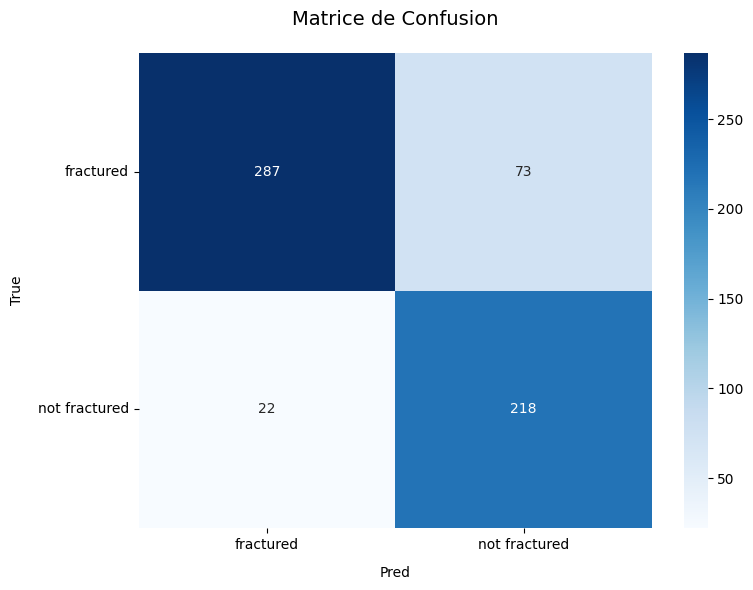

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, final_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Matrice de Confusion', pad=20, fontsize=14)
plt.xlabel('Pred', labelpad=10)
plt.ylabel('True', labelpad=10)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()